In [2]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model
from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
import sys
sys.path.append('../../../../')
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython
from dataset import Dataset

/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-19 20:11:01.488843: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-19 20:11:01.498714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 20:11:01.509412: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024

In [3]:
data = Dataset('1h')
data = data.preprocess()
# data = pd.read_csv("/home/stelios-pc/Desktop/PhD/HALCOR/temp.csv")
data.drop(columns=['Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])

# Numerical data
# scaler = MinMaxScaler() #scaler
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
# data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
# data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])
# print(data)
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
# numerical_data = scaler.fit_transform(data)

# Forming the sequences for both categorical and numerical data
n_future = 4   # Number of 15-min we want to look into the future based on the past (Out).
n_past = 12   # Number of past 15-min we want to use to predict the future (Step). Basically 4-hours
features = len(cols) - 1  # Number of features

def split_sequence(X, Y, steps, out):
    Xs, Ys = list(), list()
    for i in range(len(X)):
        end = i + steps
        outi = end + out
        if outi > len(X)-1:
            break
        seqx, seqy = X[i:end], Y[end:outi]
        Xs.append(seqx)
        Ys.append(seqy)
    return np.array(Xs), np.array(Ys)


categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data), dtype=np.int64)
data = pd.concat([data, categorical_data], axis = 1)

X = data.drop(columns='Energy')
Y = data['Energy']
# Train/test splitting
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X.values, Y.values, test_size=0.15, random_state=42, shuffle= False)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle= False)
X_train, Y_train = X_train_temp, y_train_temp


#scale only the training data, and then apply to the rest of the splits. Also two scalers, for X and Y
# n_samples, n_timesteps, n_features = X_train.shape
# X_train_reshaped = X_train.reshape(n_samples * n_timesteps, n_features)
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
# X_train = X_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

# n_samples, n_timesteps, n_features = Y_train.shape
# Y_train_reshaped = Y_train.reshape(n_samples * n_timesteps, n_features)
scaler_Y = MinMaxScaler()
Y_train = scaler_Y.fit_transform(Y_train.reshape(-1, 1))
# Y_train = Y_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)


#scale val/test sets
# X_val_reshaped = X_val.reshape(X_val.shape[0] * X_val.shape[1], X_val.shape[2])
X_val = scaler_X.transform(X_val)
# Y_val_reshaped = Y_val.reshape(Y_val.shape[0] * Y_val.shape[1], Y_val.shape[2])
Y_val = scaler_Y.transform(Y_val.reshape(-1, 1))

# X_test_reshaped = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
X_test = scaler_X.transform(X_test)
# Y_test_reshaped = Y_test.reshape(Y_test.shape[0] * Y_test.shape[1], Y_test.shape[2])
Y_test = scaler_Y.transform(Y_test.reshape(-1, 1))


print("Train sizes:")
print(X_train.shape,Y_train.shape)
print("Validation sizes:")
print(X_val.shape,Y_val.shape)
print("Test sizes:")
print(X_test.shape,Y_test.shape)

X_train , Y_train =  split_sequence(X_train, Y_train, n_past, n_future)
X_val , Y_val =  split_sequence(X_val, Y_val, n_past, n_future)
X_test , Y_test =  split_sequence(X_test, Y_test, n_past, n_future)

# del data, categorical_data, numerical_data
# del categorical_data, data

/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Multi-step Predictions/../../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Multi-step Predictions/../../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Multi-step Predictions/../../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecas

790.7322703754638
1348.9569999948144
43.16499999910593
Train sizes:
(1856, 435) (1856, 1)
Validation sizes:
(164, 435) (164, 1)
Test sizes:
(164, 435) (164, 1)


/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Multi-step Predictions/../../../../dataset.py:217: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.energy_data = self.energy_data.applymap(lambda x : np.nan if not x else x) # convert empty sets into nan so i can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Multi-step Predictions/../../../../dataset.py:220: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.energy_data = self.energy_data.fillna(method='ffill').fillna(method='bfill')


In [4]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model

from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
from scikeras.wrappers import KerasRegressor
import sys
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython


class LearningRateLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        current_lr = float(keras.backend.get_value(lr))
        print(f"\nEpoch {epoch+1}: Learning rate is {current_lr}")

lr_schedule = ExponentialDecay(
    0.0001, decay_steps=2500, decay_rate=0.96, staircase=True
)

def create_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(256, activation='relu', return_sequences=True, dropout= 0.1, recurrent_dropout= 0.1, input_shape=(X_train.shape[1], X_train.shape[2]))))
    model.add(Bidirectional(LSTM(256 *2, activation='relu', return_sequences=True, dropout= 0.1, recurrent_dropout= 0.1)))
    model.add(Bidirectional(LSTM(256 *4, activation='relu', return_sequences=True, dropout= 0.1, recurrent_dropout= 0.1)))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(4)))
    model.add(Flatten())
    model.add(Dense(n_future))
    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mape'])

    return model

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    './models/model-4-hour(1h).keras',        # Path to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Save only the best model
    mode='min',             # Save when the quantity monitored has stopped decreasing
    verbose=1               # Verbosity mode
)
model = create_model()
history = model.fit(X_train, Y_train[:, :, 0], validation_data=(X_val, Y_val[:, :, 0]), epochs=70, batch_size=8, callbacks=[checkpoint_callback, LearningRateLogger()], verbose=1, shuffle=False)

Epoch 1/70


I0000 00:00:1729358071.138396   47122 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729358071.169576   47122 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729358071.169723   47122 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729358071.170666   47122 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

  5/230 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0039 - mae: 0.0381 - mape: 86.6413

I0000 00:00:1729358080.395124   48868 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1749 - mae: 0.3359 - mape: 208485.6562
Epoch 1: val_loss improved from inf to 0.07516, saving model to ./models/model-4-hour(1h).keras

Epoch 1: Learning rate is 9.999999747378752e-05
230/230 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.1747 - mae: 0.3357 - mape: 209227.7656 - val_loss: 0.0752 - val_mae: 0.2279 - val_mape: 140.9429
Epoch 2/70
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1201 - mae: 0.2957 - mape: 236525.7812
Epoch 2: val_loss improved from 0.07516 to 0.07460, saving model to ./models/model-4-hour(1h).keras

Epoch 2: Learning rate is 9.999999747378752e-05
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.1200 - mae: 0.2955 - mape: 237365.1875 - val_loss: 0.0746 - val_mae: 0.2349 - val_mape: 123.9002
Epoch 3/70
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1024 - mae: 0.2742 - mape: 227368.6406
Epoch 3: val_loss improved from 0.07460 to 0.07191, saving model to ./models/model-4-hour(1h).keras

Epoch 3: Le

KeyboardInterrupt: 

In [5]:
from keras.models import load_model
# load model

model = load_model('./models/model-4-hour(1h).keras')
predictions = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

zeros = np.zeros((X_test.shape[0], 35))
zeros[:, :4] = predictions
predictions = scaler_Y.inverse_transform(zeros)
predictions = predictions[:, :4]


zeros = np.zeros((X_test.shape[0], 35))
zeros[:, :4] = Y_test[:, :, 0]
original = scaler_Y.inverse_transform(zeros)
original = original[:, :4]

# Calculate metrics
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    :param y_true: Actual values.
    :param y_pred: Predicted values.
    :return: MAPE value.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(original, predictions)
mse = mean_squared_error(original, predictions)
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(original, predictions)
median_ae = median_absolute_error(original, predictions)
mape = mean_absolute_percentage_error(original, predictions)


n = len(original)
p = X_test.shape[1] 
adjusted_r2_value = adjusted_r2(r2, n, p)
# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")
print(f"Median Absolute Error: {median_ae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape} %")

Mean Absolute Error (MAE): 312.44173218793355
Mean Squared Error (MSE): 159100.52065811213
Root Mean Squared Error (RMSE): 398.874066163886
R² Score: 0.05051690805871395
Adjusted R² Score: -0.03388158900273375
Median Absolute Error: 244.42624130528162
Mean Absolute Percentage Error (MAPE): 139.3718909342477 %


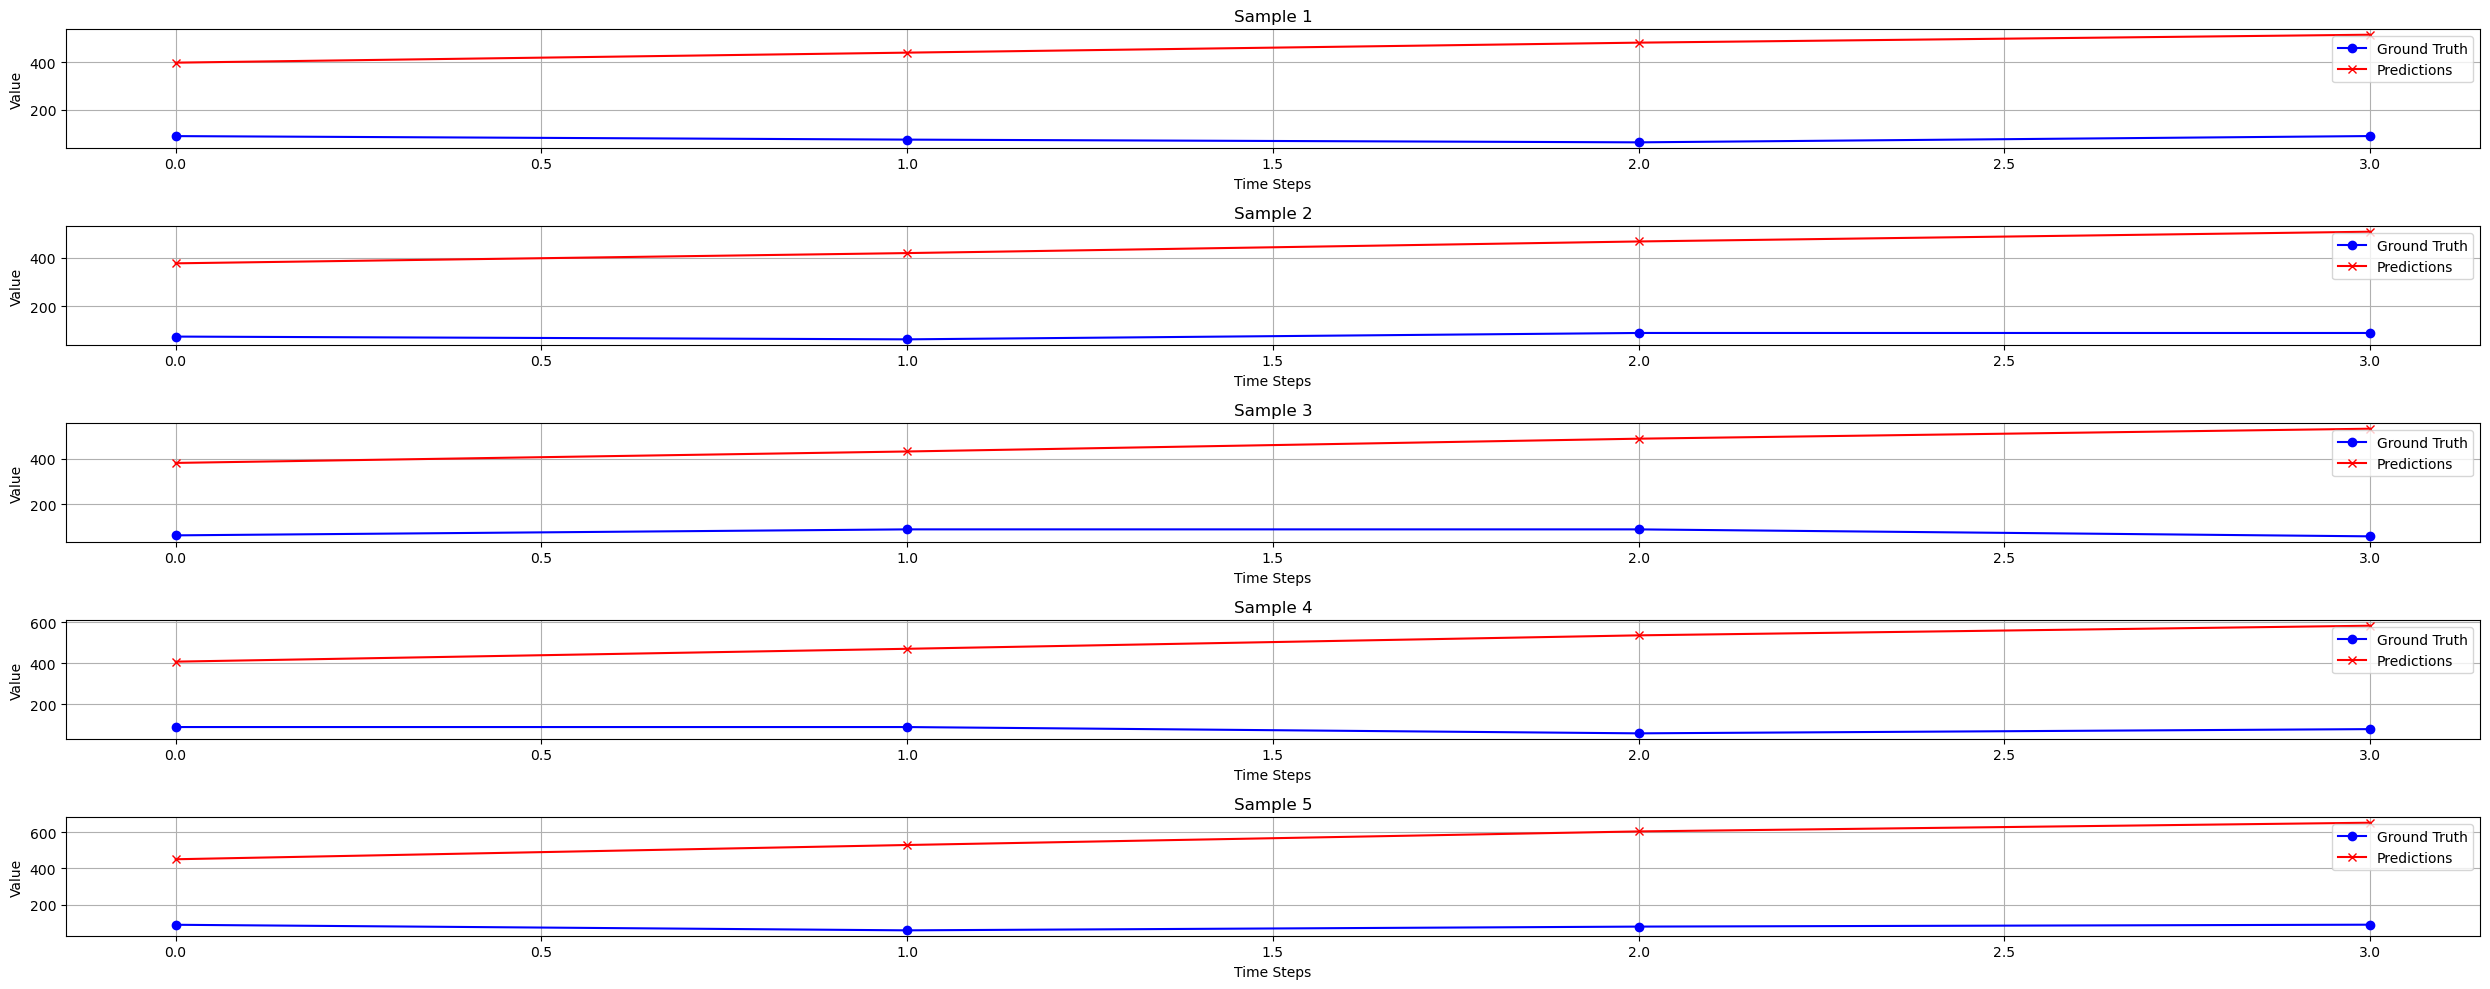

In [7]:
# Number of samples to visualize
n_samples_to_plot = 5  # Number of samples to plot

plt.figure(figsize=(25, 10))

for i in range(n_samples_to_plot):
    plt.subplot(n_samples_to_plot, 1, i + 1)
    plt.plot(range(4), original[i], marker='o', label='Ground Truth', color='blue')
    plt.plot(range(4), predictions[i], marker='x', label='Predictions', color='red')
    plt.title(f'Sample {i + 1}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
